In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import os
import pickle
from dateutil.parser import parse
import datetime
from dateutil.parser import parse
import math
from numpy import mean

from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline as SKLpipeline
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.tree import export_text
from dtreeviz.trees import dtreeviz 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as IMBLpipeline

from sklearn.inspection import permutation_importance
import shap
from matplotlib import pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

import ipynbname
notebook_name = ipynbname.name()

import seaborn as sns

pd.set_option("display.max_rows", 30)
pd.set_option("display.max_columns", 35)

In [2]:
# Define directory path name and timestamp

# Get the current date and time as a string
timestamp = datetime.datetime.now().strftime('%d%m%Y_%H%M')

# Construct the directory path with the models folder and timestamp
dir_path = f"models/{timestamp}"
    
# Create the directory if it doesn't exist
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

In [3]:
# read df pickle
df_alg = pd.read_pickle("objects/df_alg-HAB_preprocessing_5_1")
# data = pd.read_pickle("data/preprocessed/hab_org-data-HAB_part2-preprocessing-5_2")
data = pd.read_pickle("data/preprocessed/hab_interp_data-HAB_part2-preprocessing-5_2")

data.drop(columns=["sampling station", "date"], inplace=True)
# data.set_index('date', inplace=True)


# slice by station and time
# data = data[data["sampling station"] == "Debeli_rtic"].loc["2008-01-01" : "2021-12-31"]

data.isnull().sum()

DSP                        1
Dinophysis caudata         1
Dinophysis fortii          1
Phalacroma rotundatum      1
Dinophysis sacculus        1
Dinophysis tripos          1
sun [h]                    0
air temp                   0
wind strength              0
precipitation              0
Chl-a                    422
salinity                  21
T                         59
SECCHI                   450
DIN                      352
PO4-P                    349
Soca                       0
month                      0
lipophylic_toxins        320
dtype: int64

In [4]:
# Class distribution
data["lipophylic_toxins"].value_counts(dropna=False)

neg    996
NaN    320
poz    136
Name: lipophylic_toxins, dtype: int64

In [5]:
# move month to first place
cols = data.columns.tolist()  # Get a list of column names
cols = [cols[-2]] + cols[:-2] + [cols[-1]]  # Move the one before the last column to the first position
data = data[cols]

In [6]:
# data.drop(columns=["Chl-a","PO4-P","DIN","SECCHI"], inplace=True)
data.drop(columns=["SECCHI",  ], inplace=True)#,"Chl-a", "PO4-P", "DIN",
data.isnull().sum()

month                      0
DSP                        1
Dinophysis caudata         1
Dinophysis fortii          1
Phalacroma rotundatum      1
Dinophysis sacculus        1
Dinophysis tripos          1
sun [h]                    0
air temp                   0
wind strength              0
precipitation              0
Chl-a                    422
salinity                  21
T                         59
DIN                      352
PO4-P                    349
Soca                       0
lipophylic_toxins        320
dtype: int64

# Descriptive analysis

In [7]:
# describe
description = data.describe(include='all').round(0)

# Calculate the number of missing values for each column
missing_values = data.isna().sum()
missing_values.name = 'missing_values'

# Append the missing_values row to the description DataFrame
description_with_missing = description.append(missing_values)
description_with_missing = description_with_missing.drop(['unique', 'top', 'freq'])

description_with_missing

# # Descriptive statistics without decimals.
# # Generate summary statistics for the dataset and format all numbers as integers
# description = data.describe(include='all').apply(lambda x: x.apply(lambda y: "{:.0f}".format(y) if isinstance(y, (int, float)) else y))

# # Calculate the number of missing values for each column
# missing_values = data.isna().sum()
# missing_values.name = 'missing_values'

# # Append the missing_values row to the description DataFrame
# description_with_missing = description.append(missing_values)
# description_with_missing = description_with_missing.drop(['unique', 'top', 'freq'])

# # Output the modified DataFrame
# description_with_missing

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,month,DSP,Dinophysis caudata,Dinophysis fortii,Phalacroma rotundatum,Dinophysis sacculus,Dinophysis tripos,sun [h],air temp,wind strength,precipitation,Chl-a,salinity,T,DIN,PO4-P,Soca,lipophylic_toxins
count,1452.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1452.0,1452.0,1452.0,1452.0,1030.0,1431.0,1393.0,1100.0,1103.0,1452.0,1132
mean,7.0,106.0,25.0,26.0,14.0,29.0,5.0,159.0,17.0,3.0,58.0,1.0,37.0,19.0,3.0,0.0,3295.0,NaN
std,3.0,340.0,88.0,160.0,30.0,178.0,41.0,61.0,6.0,0.0,51.0,1.0,26.0,5.0,4.0,0.0,2330.0,NaN
min,1.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,-1.0,1.0,0.0,0.0,24.0,6.0,0.0,0.0,594.0,NaN
25%,5.0,10.0,0.0,0.0,0.0,0.0,0.0,113.0,12.0,3.0,20.0,0.0,36.0,16.0,1.0,0.0,1636.0,NaN
50%,8.0,37.0,0.0,0.0,10.0,0.0,0.0,161.0,17.0,3.0,45.0,1.0,37.0,20.0,2.0,0.0,2581.0,NaN
75%,10.0,90.0,13.0,10.0,20.0,10.0,0.0,207.0,22.0,3.0,79.0,1.0,37.0,24.0,4.0,0.0,4237.0,NaN
max,12.0,7630.0,1309.0,4624.0,393.0,4639.0,1139.0,278.0,27.0,5.0,268.0,9.0,999.0,28.0,35.0,4.0,16040.0,NaN
missing_values,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,422.0,21.0,59.0,352.0,349.0,0.0,320


In [8]:
# # Visualize the distribution of each variable with histograms
# num_columns = len(data.columns)
# fig, axes = plt.subplots(num_columns, 1, figsize=(10, num_columns*5))

# for i, column in enumerate(data.columns):
#     if data[column].dtype == 'float64' or data[column].dtype == 'int64':
#         sns.histplot(data=data, x=column, kde=True, ax=axes[i])
#     elif data[column].dtype == 'object':
#         sns.countplot(data=data, x=column, ax=axes[i])

#     axes[i].set_title(f'Distribution of {column}')

# plt.tight_layout()
# plt.show()

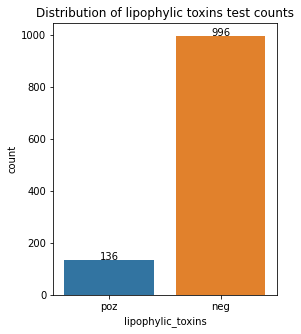

In [9]:
# Create a figure with a more narrow width
fig, ax = plt.subplots(figsize=(4, 5))

# Create a count plot
sns.countplot(data=data, x="lipophylic_toxins", ax=ax)
ax.set_title('Distribution of lipophylic toxins test counts')

# Add numbers on top of the bars
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height() + 0.5,
            p.get_height(), ha='center', fontsize=10)

# Show the plot
plt.savefig(f"{dir_path}/lipophylic_toxins_test_counts-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300)
plt.show()

In [10]:
# # Visualize the distribution of each variable using vertical violin plots
# num_columns = len(data.columns)
# fig, axes = plt.subplots(num_columns, 1, figsize=(6, num_columns*4))

# for i, column in enumerate(data.columns):
#     if data[column].dtype == 'float64' or data[column].dtype == 'int64':
#         sns.violinplot(data=data, y=column, ax=axes[i])
#         axes[i].set_title(f'Violin plot of {column}')
#     else:
#         # Skip categorical columns for violin plots
#         axes[i].set_visible(False)

# plt.tight_layout()
# plt.show()

## Descriptive analysis by month

In [11]:
# table of mean values for each feature by month 
import calendar

grouped_means = data.groupby('month').mean()

# Count binary values for the categorical feature grouped by month
binary_counts = data.groupby('month')['lipophylic_toxins'].value_counts().unstack()

# Calculate the ratio of positive values for each month
sum_positive = binary_counts["poz"].sum()
positive_ratios = [i for i in (binary_counts["poz"] / sum_positive)] 
positive_ratios = [round(v * 100, 1) for v in positive_ratios]

# Change month names
month_names = {i: calendar.month_name[i] for i in range(1, 13)}

# Update the index using the month_names dictionary
grouped_means.index = grouped_means.index.map(month_names)
binary_counts.index = binary_counts.index.map(month_names)

# Concatenate the grouped_means and binary_counts DataFrames
result = pd.concat([grouped_means, binary_counts], axis=1).round(2)

# Add the positive_ratios Series as a new column to the result DataFrame
result["poz %"] = positive_ratios

result

,DSP,Dinophysis caudata,Dinophysis fortii,Phalacroma rotundatum,Dinophysis sacculus,Dinophysis tripos,sun [h],air temp,wind strength,precipitation,Chl-a,salinity,T,DIN,PO4-P,Soca,neg,poz,poz %
month,,,,,,,,,,,,,,,,,,,
January,9.00,1.16,2.96,3.66,0.09,0.20,72.62,4.95,2.71,46.53,0.76,36.95,11.07,6.79,0.07,4652.16,15,3,2.2
February,12.86,1.02,4.08,3.38,0.20,0.69,80.19,5.52,3.06,60.66,0.77,37.02,10.22,6.66,0.08,4378.79,21,3,2.2
March,12.38,0.21,0.68,3.79,0.43,0.64,118.56,7.55,3.30,30.01,0.77,37.17,9.49,4.37,0.05,3257.07,28,2,1.5
April,15.49,0.97,0.48,5.24,4.51,0.00,144.63,11.69,3.17,54.90,0.68,36.93,11.68,4.68,0.06,3826.10,66,2,1.5
May,59.00,6.00,0.97,9.67,34.25,0.15,171.96,16.22,2.89,48.55,0.96,36.57,14.87,3.92,0.07,3864.97,89,14,10.3
June,146.89,29.23,1.49,12.87,93.28,0.09,202.85,20.51,2.83,45.16,1.09,35.60,20.28,3.58,0.13,3436.93,115,12,8.8
July,237.04,67.07,44.50,19.57,97.25,0.04,227.47,23.31,2.88,38.27,0.75,35.40,23.48,3.38,0.05,2473.18,125,18,13.2
August,129.67,55.46,24.23,19.01,22.96,0.08,220.46,23.46,3.03,54.38,0.63,41.92,24.93,2.03,0.05,1637.28,126,11,8.1
September,116.79,28.04,58.58,12.81,3.57,6.04,174.65,20.06,3.11,69.73,0.64,36.59,24.38,2.06,0.05,2102.01,143,31,22.8


In [12]:
# # Visualise numeric data distribution by month

# # Get the numerical columns
# numerical_columns = data.iloc[:, 1:-1].columns

# # Plot the distribution of each numerical variable by month
# num_numerical = len(numerical_columns)
# fig, axes = plt.subplots(num_numerical, 1, figsize=(10, num_numerical * 4))

# for i, column in enumerate(numerical_columns):
#     sns.lineplot(data=data, x='month', y=column, ax=axes[i], ci=None)
#     axes[i].set_title(f'Distribution of {column} by month')

# plt.tight_layout()
# plt.show()


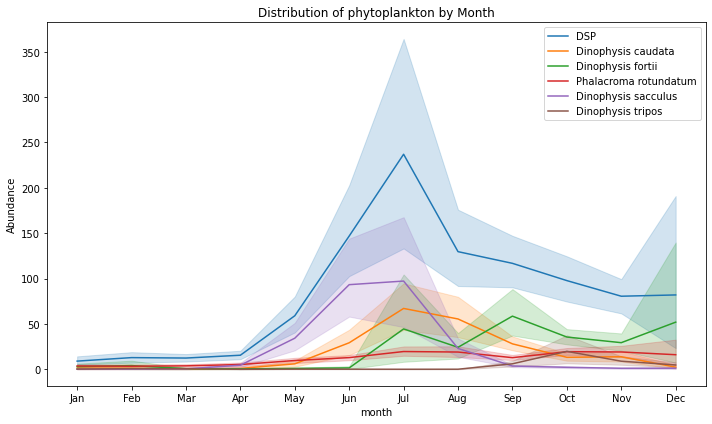

In [13]:
# Plot phytoplantkon distribution by month
# Get the phytoplankton columns
phytoplankton = data.iloc[:, 1:7].columns

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the distribution of each of the first 6 numerical variables by month on the same plot
for column in phytoplankton:
    sns.lineplot(data=data, x='month', y=column, ax=ax, label=column)

# Customize the plot
ax.set_title('Distribution of phytoplankton by Month')
ax.set_ylabel('Abundance')  # Set the y-axis label to "Abundance"
ax.legend()

# Customize the x-axis ticks and labels to show only month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(1, 13), month_names)

# Save and show the plot
plt.tight_layout()
plt.savefig(f"{dir_path}/phytoplankton_abundance_distribution_by_month-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300)
plt.show()

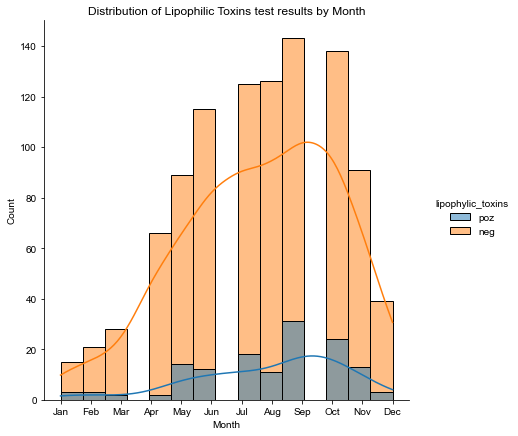

In [14]:
# Visualise target variable distribution by month
# Create a displot with hue
sns.displot(data=data, x="month", hue="lipophylic_toxins", kde=True, height=6)

# Customize the x-axis ticks and labels
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Customize the plot if desired
sns.set_style("whitegrid")
sns.set_palette("Set2")
plt.title('Distribution of Lipophilic Toxins test results by Month')
plt.xlabel('Month')
plt.ylabel('Count')

# Show the plot
plt.savefig(f"{dir_path}/target_distribution_month-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()

# Data preprocessing for modelling

## Removing instances with unlabeled target, label encoding

In [15]:
# Prepare for ML in scikit-learn
# labeled and unlabeled part
data_l = data[data['lipophylic_toxins'].notnull()]
data_ul = data[data['lipophylic_toxins'].isnull()]

# Remove missing values
data_l = data_l.dropna(how="any")
print(f"class distribution:")
print(data_l["lipophylic_toxins"].value_counts(dropna=False))

X = data_l.drop("lipophylic_toxins", axis=1)
y = data_l["lipophylic_toxins"]

# sklearn lable encoding
le = LabelEncoder()
le.fit(y)
y = le.transform(y)
print(f"class encoding: ['neg','poz'] -> {le.transform(['neg','poz'])}")

class distribution:
neg    662
poz     88
Name: lipophylic_toxins, dtype: int64
class encoding: ['neg','poz'] -> [0 1]


## Clean instances close to the decision boundary

Clean the dataset by removing samples close to the decision boundary. Because the dataset is heavily imbalanced in favor of clas 0 (neg) we will remove instances from this class whenever finding samples which do not agree “enough” with their neighboorhood. The EditedNearestNeighbours will be used. One other option is to use Tomek links but it is more conservative and was found to perform slightly worse.

In [16]:
from collections import Counter
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours

print(f'Original dataset shape: {Counter(y)}')
usmp = EditedNearestNeighbours()
lastMajorityCount = Counter(y)[0]
for i in range(10):
    X_res, y_res = usmp.fit_resample(X, y)
    if Counter(y_res)[0] == lastMajorityCount:
        print('Cannot remove any more samples')
        break
    else:
        print(f'Resampled dataset shape {Counter(y_res)}')
        lastMajorityCount = Counter(y_res)[0]
    X = X_res
    y = y_res

Original dataset shape: Counter({0: 662, 1: 88})
Resampled dataset shape Counter({0: 540, 1: 88})
Resampled dataset shape Counter({0: 501, 1: 88})
Resampled dataset shape Counter({0: 490, 1: 88})
Resampled dataset shape Counter({0: 488, 1: 88})
Resampled dataset shape Counter({0: 487, 1: 88})
Cannot remove any more samples


## Train-test split

In [17]:
# All data
import copy

X_all = copy.copy(X)
y_all = copy.copy(y)

# train test split
X, X_eval, y, y_eval = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.30, random_state=42)

# Correlation analysis on training data

In [18]:
# Calculate Pearson correlation between numeric features and binary target variable
pearson_correlations = X.corrwith(pd.Series(y), method='pearson')
pearson_correlations.name = 'Pearson'


# Combine the correlation values into a single dataframe
corr_df = pd.concat([pearson_correlations], axis=1)

# Create a new column for absolute Spearman correlation values
corr_df['Pearson_abs'] = corr_df['Pearson'].abs()

# Sort the dataframe by absolute Spearman correlation values
corr_df_sorted = corr_df.sort_values(by=['Pearson_abs'], ascending=False)

# Drop the absolute Spearman correlation column and return the sorted dataframe
corr_df_ranked = corr_df_sorted.drop(columns=['Pearson_abs'])

corr_df_ranked

,Pearson
Dinophysis caudata,0.159930
T,0.133431
air temp,0.101362
Chl-a,-0.081980
month,0.079418
Dinophysis tripos,0.076581
salinity,-0.055177
DSP,0.050517
DIN,0.048785
sun [h],0.048582


# Model Training and Evaluation

In [19]:
# Saving models

# Function to save best estimator
def save_best_estimator(grid_search_cv, classifier_name, notebook_name):
    # Get the best estimator from the GridSearchCV object
    best_estimator = grid_search_cv.best_estimator_

    # Construct the file name with the classifier name and notebook name
    pickle_file_name = f"{dir_path}/{classifier_name}-{notebook_name}-{timestamp}.pkl"
    
    # Save the best estimator to the file
    with open(pickle_file_name, 'wb') as f:
        pickle.dump(best_estimator, f)

    print(f"Best estimator saved as: {pickle_file_name}")

In [20]:
# Function for loading saved models

def load_best_estimator(pickle_file_name):
    with open(pickle_file_name, 'rb') as f:
        best_estimator = pickle.load(f)
    return best_estimator

## SVM

In [21]:
pd.set_option("display.max_rows", None)

pipeline = IMBLpipeline([
    ('smt', SMOTE()), 
    ('under', RandomUnderSampler()), 
    ('clf', SVC())
])

parameters = {
            'clf__C': [0.1, 0.5, 1, 3, 10, 100],
            # 'clf__gamma': ['scale', 'auto'],
            # 'clf__kernel': ['linear', 'rbf', 'poly'],
            'clf__class_weight': ['balanced', None],
            'smt__sampling_strategy': [ 0.2, 0.3, 0.4],
            'under__sampling_strategy': [0.5, 0.6, 0.7],
            'smt__k_neighbors': [1, 3, 5]
             }
nfolds = 3
scores = ['recall', 'precision', 'f1', 'roc_auc', 'recall_weighted']
gscv_svm = GridSearchCV(pipeline, 
                    parameters, 
                    scoring=scores,
                    cv=StratifiedKFold(n_splits=nfolds, shuffle=True),
                    return_train_score=False, 
                    verbose=1, 
                    refit="f1",
                    n_jobs=-1)
resultsGSCV = gscv_svm.fit(X, y)

# Get the classifier name from the pipeline
classifier_name = resultsGSCV.best_estimator_.named_steps['clf'].__class__.__name__
    
# save the best estimator
save_best_estimator(gscv_svm, classifier_name, notebook_name)

results = pd.DataFrame(resultsGSCV.cv_results_)
display(results.sort_values(by=[f'rank_test_f1']).transpose())

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best estimator saved as: models/01052023_0151/SVC-HAB_modelling_6_1-01052023_0151.pkl


,286,312,273,321,288,299,282,283,275,303,300,271,316,284,319,308,292,...,39,40,41,42,43,44,82,46,47,48,49,50,51,52,53,37,81
mean_fit_time,0.023615,0.022565,0.023091,0.024445,0.021789,0.020811,0.023012,0.022775,0.022429,0.022747,0.021594,0.019264,0.019539,0.021847,0.021211,0.018338,0.023593,...,0.01883,0.020816,0.017946,0.021334,0.021462,0.020505,0.02098,0.018431,0.01751,0.019551,0.021471,0.020452,0.023415,0.020755,0.020108,0.019189,0.022332
std_fit_time,0.001251,0.000494,0.001078,0.003004,0.002034,0.001389,0.001686,0.001096,0.000919,0.001166,0.000689,0.000878,0.00077,0.000953,0.000272,0.000279,0.002279,...,0.000169,0.001622,0.000457,0.002189,0.001605,0.000805,0.002567,0.000488,0.000987,0.00087,0.00126,0.001729,0.004129,0.000573,0.00066,0.002471,0.000601
mean_score_time,0.020998,0.019282,0.01947,0.01602,0.017254,0.015283,0.020293,0.019429,0.018229,0.018692,0.017148,0.016774,0.016293,0.018319,0.016719,0.015792,0.018226,...,0.01653,0.017543,0.016878,0.020927,0.019289,0.019789,0.015839,0.016325,0.015606,0.01725,0.017304,0.018013,0.018018,0.01868,0.017796,0.014649,0.017534
std_score_time,0.000537,0.001217,0.001354,0.001906,0.00155,0.000208,0.001452,0.000229,0.000853,0.000939,0.000077,0.0011,0.001298,0.000995,0.00075,0.001708,0.000941,...,0.000838,0.001715,0.000749,0.001679,0.000236,0.00017,0.000212,0.001435,0.000315,0.000489,0.000791,0.001973,0.001572,0.000695,0.000747,0.000111,0.001018
param_clf__C,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,0.1,0.1,0.1,0.1,0.1,0.1,0.5,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.5
param_clf__class_weight,balanced,None,balanced,None,balanced,None,balanced,balanced,balanced,None,None,balanced,None,balanced,None,None,balanced,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
param_smt__k_neighbors,3,3,1,5,5,1,3,3,1,1,1,1,5,3,5,3,5,...,3,3,3,3,3,3,1,5,5,5,5,5,5,5,5,3,1
param_smt__sampling_strategy,0.4,0.4,0.3,0.4,0.2,0.2,0.3,0.3,0.3,0.4,0.3,0.2,0.2,0.3,0.3,0.2,0.3,...,0.3,0.3,0.3,0.4,0.4,0.4,0.2,0.2,0.2,0.3,0.3,0.3,0.4,0.4,0.4,0.2,0.2
param_under__sampling_strategy,0.6,0.5,0.5,0.5,0.5,0.7,0.5,0.6,0.7,0.5,0.5,0.6,0.6,0.7,0.6,0.7,0.6,...,0.5,0.6,0.7,0.5,0.6,0.7,0.6,0.6,0.7,0.5,0.6,0.7,0.5,0.6,0.7,0.6,0.5
params,"{'clf__C': 100, 'clf__class_weight': 'balanced...","{'clf__C': 100, 'clf__class_weight': None, 'sm...","{'clf__C': 100, 'clf__class_weight': 'balanced...","{'clf__C': 100, 'clf__class_weight': None, 'sm...","{'clf__C': 100, 'clf__class_weight': 'balanced...","{'clf__C': 100, 'clf__class_weight': None, 'sm...","{'clf__C': 100, 'clf__class_weight': 'balanced...","{'clf__C': 100, 'clf__class_weight': 'balanced...","{'clf__C': 100, 'clf__class_weight': 'balanced...","{'clf__C': 100, 'clf__class_weight': None, 'sm...","{'clf__C': 100, 'clf__class_weight': None, 'sm...","{'clf__C': 100, 'clf__class_weight': 'balanced...","{'clf__C': 100, 'clf__class_weight': None, 'sm...","{'clf__C': 100, 'clf__class_weight': 'balanced...","{'clf__C': 100, 'clf__class_weight': None, 'sm...","{'clf__C': 100, 'clf__class_weight': None, 'sm...","{'clf__C': 100, 'clf__class_weight': 'balanced...",...,"{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.5, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.1, 'clf__class_weight': None, 'sm...","{'clf__C': 0.5, 'clf__class_weight': None, 's

In [22]:
# Evaluation on test data
svm_clf = gscv_svm.best_estimator_.steps[2][1]

# # Load the best estimator from the saved pickle file (replace with acctual file name)
# pickle_file_name = "models/timestamp/classifier_name-notebook_name.pkl"
# svm_clf = load_best_estimator(pickle_file_name).steps[2][1]

# Evaluation on test data
from sklearn.metrics import classification_report
y_pred = svm_clf.predict(X_eval)
SVM_classification_report = classification_report(y_eval, y_pred)

# Create classification report as dictionary
SVM_report_dict = classification_report(y_eval, y_pred, output_dict=True)

print(classification_report(y_eval, y_pred, target_names=["neg", "poz"]))

              precision    recall  f1-score   support

         neg       0.93      0.71      0.80       147
         poz       0.30      0.69      0.41        26

    accuracy                           0.71       173
   macro avg       0.61      0.70      0.61       173
weighted avg       0.83      0.71      0.74       173



## Decision Tree Model (sklearn)

In [23]:
pd.set_option("display.max_rows", None)

pipeline = IMBLpipeline([
    ('smt', SMOTE()), 
    ('under', RandomUnderSampler()), 
    ('clf', DecisionTreeClassifier())
])

parameters = {
            'clf__max_depth': [2,3,4],
            'clf__criterion': ['gini', 'entropy', 'log_loss'],
               'clf__class_weight': ['balanced', None],
               'smt__sampling_strategy': [ 0.2, 0.3, 0.4],
               'under__sampling_strategy': [0.5, 0.6, 0.7],
               'smt__k_neighbors': [1, 3, 5]
             }
nfolds = 3
scores = ['recall', 'precision', 'f1', 'roc_auc', 'recall_weighted']
gscv_dt = GridSearchCV(pipeline, 
                    parameters, 
                    scoring=scores,
                    cv=StratifiedKFold(n_splits=nfolds, shuffle=True),
                    return_train_score=False, 
                    verbose=1, 
                    refit="f1",
                    n_jobs=-1)
resultsGSCV = gscv_dt.fit(X, y)

# Get the classifier name from the pipeline
classifier_name = resultsGSCV.best_estimator_.named_steps['clf'].__class__.__name__
    
# save the best estimator
save_best_estimator(gscv_dt, classifier_name, notebook_name)

results = pd.DataFrame(resultsGSCV.cv_results_)
display(results.sort_values(by=[f'rank_test_f1']).transpose())

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Best estimator saved as: models/01052023_0151/DecisionTreeClassifier-HAB_modelling_6_1-01052023_0151.pkl


,400,244,344,318,469,279,393,415,432,50,258,406,431,271,281,387,413,...,176,99,467,297,225,195,330,95,169,81,165,283,417,423,332,408,166
mean_fit_time,0.019654,0.021353,0.022369,0.022148,0.018893,0.019964,0.023435,0.022526,0.02072,0.021718,0.022808,0.020734,0.019715,0.021131,0.018297,0.020711,0.02178,...,0.018817,0.020909,0.019772,0.02674,0.020283,0.021591,0.023173,0.020079,0.019671,0.018956,0.02104,0.020577,0.020073,0.020398,0.023317,0.019665,0.018591
std_fit_time,0.000336,0.002572,0.003027,0.002474,0.000987,0.001674,0.001609,0.006386,0.001632,0.001159,0.003742,0.00061,0.000396,0.002917,0.000375,0.001303,0.003022,...,0.000107,0.001081,0.000433,0.005918,0.000277,0.001732,0.000176,0.001081,0.000899,0.000692,0.001815,0.001745,0.000962,0.000915,0.004915,0.001484,0.000298
mean_score_time,0.014038,0.011941,0.012812,0.011863,0.012163,0.012071,0.012247,0.014385,0.011864,0.013453,0.011812,0.012799,0.012261,0.011733,0.012172,0.013058,0.011537,...,0.011382,0.011956,0.010991,0.016504,0.012827,0.013357,0.013394,0.011499,0.012487,0.011504,0.011728,0.01228,0.012913,0.011964,0.013166,0.011622,0.011003
std_score_time,0.002772,0.000228,0.002095,0.000872,0.001569,0.000895,0.000893,0.003478,0.000756,0.000868,0.000563,0.001198,0.001095,0.000762,0.001525,0.002271,0.000187,...,0.000343,0.00038,0.000321,0.004492,0.000923,0.002979,0.000577,0.000293,0.001755,0.000116,0.000929,0.001319,0.001888,0.000322,0.001614,0.00048,0.000238
param_clf__class_weight,None,None,None,None,None,None,None,None,None,balanced,None,None,None,None,None,None,None,...,balanced,balanced,None,None,balanced,balanced,None,balanced,balanced,balanced,balanced,None,None,None,None,None,balanced
param_clf__criterion,entropy,gini,entropy,gini,log_loss,gini,entropy,log_loss,log_loss,gini,gini,log_loss,log_loss,gini,gini,entropy,log_loss,...,log_loss,entropy,log_loss,gini,log_loss,log_loss,entropy,entropy,log_loss,entropy,log_loss,gini,log_loss,log_loss,entropy,log_loss,log_loss
param_clf__max_depth,4,2,2,4,4,3,4,2,3,3,2,2,2,3,3,4,2,...,2,2,4,4,4,3,2,2,2,2,2,3,2,2,2,2,2
param_smt__k_neighbors,5,1,5,5,3,3,3,3,1,5,3,1,5,1,3,3,1,...,3,5,1,1,3,1,1,3,1,1,1,3,3,5,1,1,1
param_smt__sampling_strategy,0.3,0.2,0.2,0.3,0.2,0.2,0.4,0.2,0.2,0.3,0.4,0.2,0.4,0.2,0.2,0.2,0.4,...,0.3,0.2,0.4,0.2,0.2,0.4,0.4,0.3,0.4,0.2,0.3,0.3,0.3,0.2,0.4,0.3,0.3
param_under__sampling_strategy,0.6,0.6,0.7,0.5,0.6,0.5,0.5,0.6,0.5,0.7,0.5,0.6,0.7,0.6,0.7,0.5,0.7,...,0.7,0.5,0.7,0.5,0.5,0.5,0.5,0.7,0.6,0.5,0.5,0.6,0.5,0.5,0.7,0.5,0.6


In [24]:
# Evaluation on test data
dt_clf = gscv_dt.best_estimator_.steps[2][1]

# # Load the best estimator from the saved pickle file (replace with acctual file name)
# pickle_file_name = "models/12042023_1718/DecisionTreeClassifier-HAB_modelling_5_8-12042023_1718.pkl"
# dt_clf = load_best_estimator(pickle_file_name).steps[2][1]

y_pred = dt_clf.predict(X_eval)
DT_classification_report = classification_report(y_eval, y_pred)

# Create classification report as dictionary
DT_report_dict = classification_report(y_eval, y_pred, output_dict=True)

print(classification_report(y_eval, y_pred, target_names=["neg", "poz"]))

              precision    recall  f1-score   support

         neg       0.93      0.79      0.85       147
         poz       0.35      0.65      0.46        26

    accuracy                           0.77       173
   macro avg       0.64      0.72      0.66       173
weighted avg       0.84      0.77      0.79       173



X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


Visualization saved as: models/01052023_0151/DT_visualisation.svg


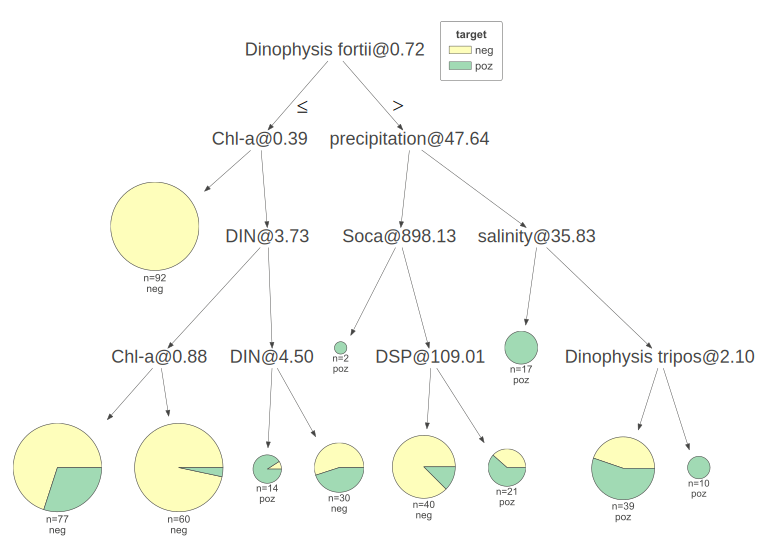

In [25]:
viz = dtreeviz(dt_clf, X, y,
                target_name="target",
                feature_names=X.columns,
                class_names=["neg", "poz"],
             fancy=False,
               scale=1.5
              )

# Save the visualization as a PNG file
viz_file_name = f"{dir_path}/DT_visualisation.svg"
viz.save(viz_file_name)
print(f"Visualization saved as: {viz_file_name}")

# Display the visualization
viz

## Random Forest Model

#### Model evaluation (Random Forest)

In [26]:
# Random forest with grid search for parameters, testing on 5-fold CV with shuffling

pipeline = IMBLpipeline([
   ('smt', SMOTE()), 
   ('under', RandomUnderSampler()), 
    ('clf', RandomForestClassifier())
])

parameters = {
              'clf__n_estimators': [100,300,500],
              'clf__criterion': ['gini', 'entropy', 'log_loss'],
              'clf__class_weight': ['balanced', 'balanced_subsample', None],
              'smt__sampling_strategy': [ 0.2, 0.3, 0.4],
              'under__sampling_strategy': [0.5, 0.6, 0.7],
              'smt__k_neighbors': [3, 5]
             }

nfolds = 3
scores = ['recall', 'precision', 'f1', 'roc_auc']
refit_score = 'f1'
gscv_rf = GridSearchCV(pipeline, 
                    parameters, 
                    scoring=scores,
                    cv=StratifiedKFold(n_splits=nfolds, shuffle=True),
                    return_train_score=False, 
                    verbose=1, 
                    refit=refit_score,
                    n_jobs=-1)
resultsGSCV = gscv_rf.fit(X, y)

# Get the classifier name from the pipeline
classifier_name = resultsGSCV.best_estimator_.named_steps['clf'].__class__.__name__
    
# save the best estimator
save_best_estimator(gscv_rf, classifier_name, notebook_name)

results = pd.DataFrame(resultsGSCV.cv_results_)
display(results.sort_values(by=[f'rank_test_f1']).transpose())
pd.set_option("display.max_rows", None)

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Best estimator saved as: models/01052023_0151/RandomForestClassifier-HAB_modelling_6_1-01052023_0151.pkl


,308,310,314,344,116,428,373,73,436,334,194,478,288,483,451,394,329,...,188,89,18,380,10,378,270,313,262,388,65,226,3,263,164,13,144
mean_fit_time,1.891511,1.911023,2.188538,0.801138,0.28848,1.428773,1.369805,0.735258,0.321123,0.284159,0.930412,1.586676,0.994601,1.774104,0.864847,0.339314,0.310439,...,0.975941,0.810371,0.76112,0.27987,0.256595,0.28366,0.34531,2.06179,1.786166,0.281225,0.254061,0.333033,0.269,1.772691,0.31136,0.254653,1.297426
std_fit_time,0.049414,0.006756,0.012055,0.006493,0.005049,0.00329,0.020195,0.002933,0.00455,0.011556,0.00695,0.012247,0.012026,0.018078,0.012935,0.012238,0.004204,...,0.001946,0.014324,0.006388,0.004837,0.005558,0.012753,0.003619,0.023548,0.019193,0.00519,0.003124,0.002763,0.0109,0.010398,0.003725,0.005223,0.001709
mean_score_time,0.263459,0.247475,0.237487,0.140096,0.055763,0.239932,0.231177,0.128179,0.059729,0.058143,0.142819,0.260408,0.143194,0.226235,0.164641,0.063025,0.057466,...,0.142841,0.132073,0.121871,0.06165,0.047632,0.052558,0.058648,0.321564,0.252805,0.059516,0.051642,0.055982,0.050451,0.256418,0.055012,0.049573,0.220736
std_score_time,0.00371,0.006182,0.004331,0.003323,0.002189,0.004214,0.004079,0.002734,0.000607,0.003938,0.003076,0.002094,0.00302,0.008093,0.002772,0.004316,0.002092,...,0.007545,0.002483,0.001384,0.002029,0.000431,0.000489,0.002358,0.005388,0.004203,0.000177,0.002333,0.000767,0.002957,0.009529,0.002754,0.001803,0.002108
param_clf__class_weight,balanced_subsample,balanced_subsample,balanced_subsample,None,balanced,None,None,balanced,None,None,balanced_subsample,None,balanced_subsample,None,None,None,None,...,balanced_subsample,balanced,balanced,None,balanced,None,balanced_subsample,balanced_subsample,balanced_subsample,None,balanced,balanced_subsample,balanced,balanced_subsample,balanced_subsample,balanced,balanced
param_clf__criterion,log_loss,log_loss,log_loss,gini,log_loss,entropy,gini,entropy,log_loss,gini,gini,log_loss,log_loss,log_loss,log_loss,entropy,gini,...,gini,entropy,gini,entropy,gini,entropy,log_loss,log_loss,entropy,entropy,entropy,entropy,gini,entropy,gini,gini,log_loss
param_clf__n_estimators,500,500,500,300,100,500,500,300,100,100,300,500,300,500,300,100,100,...,300,300,300,100,100,100,100,500,500,100,100,100,100,500,100,100,500
param_smt__k_neighbors,3,3,3,3,3,5,5,3,3,5,5,5,3,5,3,5,3,...,3,5,3,3,5,3,3,3,5,5,5,5,3,5,3,5,3
param_smt__sampling_strategy,0.2,0.3,0.4,0.2,0.4,0.3,0.3,0.2,0.3,0.2,0.3,0.2,0.2,0.4,0.2,0.4,0.3,...,0.4,0.4,0.2,0.2,0.2,0.2,0.2,0.4,0.2,0.2,0.2,0.2,0.3,0.2,0.2,0.3,0.2
param_under__sampling_strategy,0.7,0.6,0.7,0.7,0.7,0.7,0.6,0.6,0.6,0.6,0.7,0.6,0.5,0.5,0.6,0.6,0.7,...,0.7,0.7,0.5,0.7,0.6,0.5,0.5,0.6,0.6,0.6,0.7,0.6,0.5,0.7,0.7,0.6,0.5


In [27]:
# Evaluation on test data
rf_clf = gscv_rf.best_estimator_.steps[2][1]

# # Load the best estimator from the saved pickle file (replace with acctual file name)
# pickle_file_name = "models/timestamp/classifier_name-notebook_name.pkl"
# rf_clf = load_best_estimator(pickle_file_name).steps[2][1]

# Evaluation RF on test set
y_pred = rf_clf.predict(X_eval)
RF_classification_report = classification_report(y_eval, y_pred)

# Create classification report as dictionary
RF_report_dict = classification_report(y_eval, y_pred, output_dict=True)

print(classification_report(y_eval, y_pred, target_names=["neg", "poz"]))

              precision    recall  f1-score   support

         neg       0.93      0.81      0.87       147
         poz       0.38      0.65      0.48        26

    accuracy                           0.79       173
   macro avg       0.65      0.73      0.67       173
weighted avg       0.85      0.79      0.81       173



Plot the mean ROC curve of the algorithm with best performing parameter selection. We will perform CV once again and plot the ROC curve for each fold and compute and plot the mean.

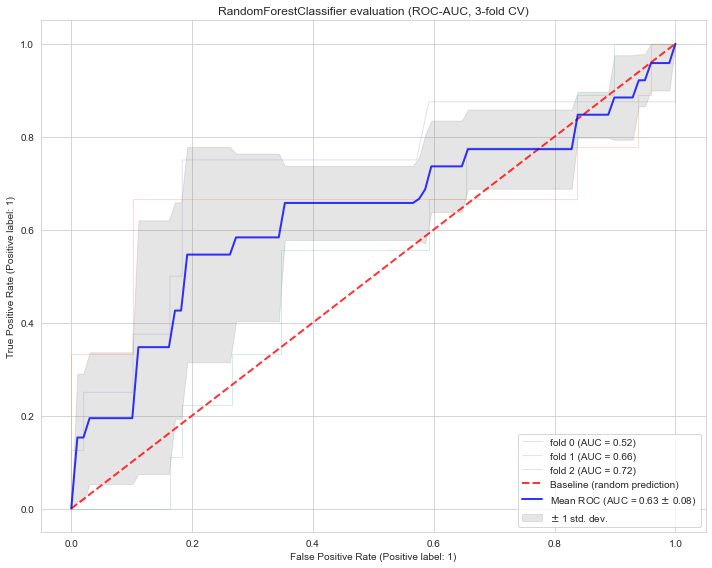

In [28]:
# Plot the ROC curve for RF

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=3, shuffle=True)
classifier = resultsGSCV.best_estimator_

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10,8))
for i, (train, test) in enumerate(cv.split(X_eval, y_eval)):
    classifier.fit(X_eval.iloc[train], y_eval[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X_eval.iloc[test],
        y_eval[test],
        name="fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Baseline (random prediction)", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

clfname = [str(step[1].__class__.__name__) for step in classifier.steps if step[0]=='clf'][0]
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f'{clfname} evaluation (ROC-AUC, {nfolds}-fold CV)',
)
ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"{dir_path}/RF_ROC_curve-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300)
plt.show()

Plot the mean precision-recall curve. The approach is the same as for the mean ROC curve.

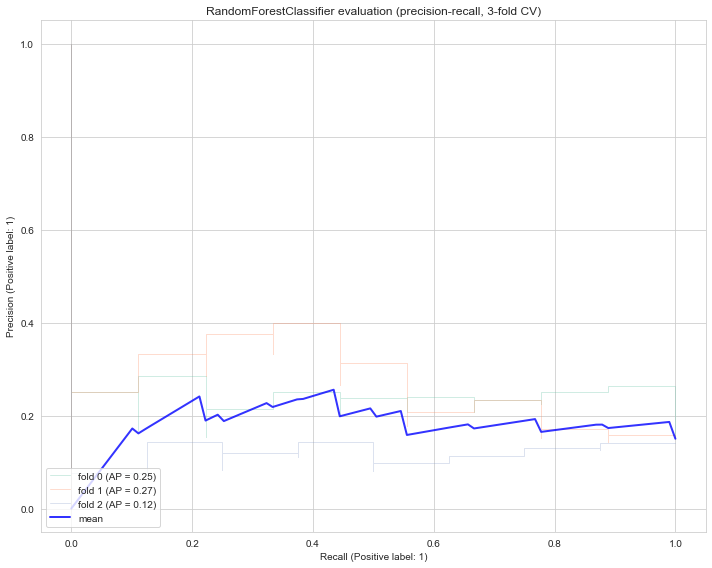

In [29]:
# Plot the mean precision-recall curve. 

from sklearn.metrics import PrecisionRecallDisplay

cv = StratifiedKFold(n_splits=3, shuffle=True)
classifier = resultsGSCV.best_estimator_

prs = []
aucs = []
mean_r = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10,8))
for i, (train, test) in enumerate(cv.split(X_eval, y_eval)):
    classifier.fit(X_eval.iloc[train], y_eval[train])
    viz = PrecisionRecallDisplay.from_estimator(
        classifier,
        X_eval.iloc[test],
        y_eval[test],
        name="fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_pr = np.interp(mean_r, viz.recall[::-1], viz.precision[::-1])
    prs.append(interp_pr)

mean_p = np.mean(prs, axis=0)
ax.plot(
    mean_r,
    mean_p,
    color="b",
    label=f"mean",
    lw=2,
    alpha=0.8,
)
ax.legend(loc="lower left")
clfname = [str(step[1].__class__.__name__) for step in classifier.steps if step[0]=='clf'][0]
ax.set(
    # xlim=[-0.05, 1.05],
    # ylim=[-0.05, 1.05],
    title=f'{clfname} evaluation (precision-recall, {nfolds}-fold CV)')
plt.tight_layout()
plt.savefig(f"{dir_path}/RF_precision-recall_curve-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300)
plt.show()

#### Feature importance (Random Forest)

Text(0.5, 1.0, 'Permutation Importance Random Forest')

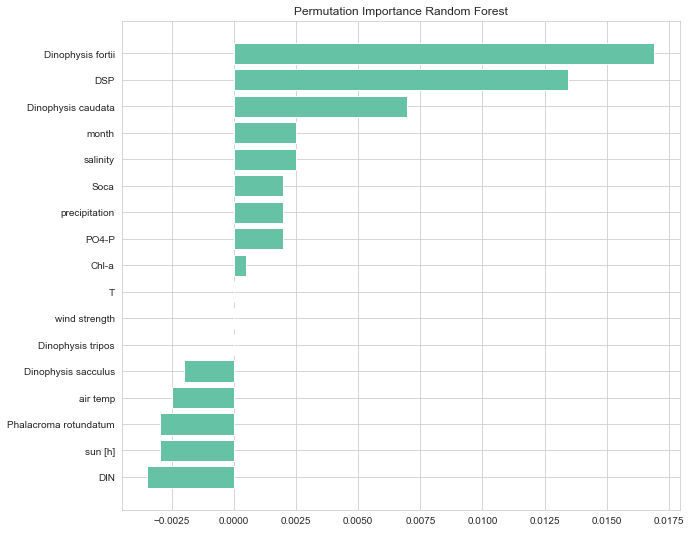

In [30]:
# Feature importance of model (best RandomForest from gridsearch) with three methods!

fig, (ax2) = plt.subplots(1, 1, figsize=(10,9))
plt.subplots_adjust(wspace=1.1)

# Get feature importance with Permutation Based Feature Importance (randomly shuffles each feature and compute the 
# change in the model’s performance. The features which impact the performance the most are the most important one).
perm_importance = permutation_importance(rf_clf, X, y)
perm_sorted_idx = perm_importance.importances_mean.argsort()
x2 = X.columns[perm_sorted_idx]
y2 = perm_importance.importances_mean[perm_sorted_idx]
ax2.barh(x2, y2)
ax2.set_title("Permutation Importance Random Forest")

### SHAP

In [31]:
# # Get feature importance with SHAP
# explainer = shap.TreeExplainer(rf)
# shap_values = explainer.shap_values(X)
# RF_shap = shap.summary_plot(shap_values, X, plot_type="bar")

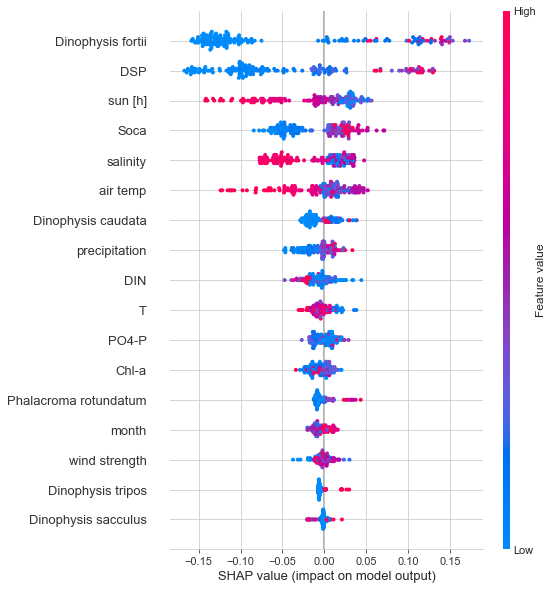

In [32]:
# SHAP summary plot
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_eval)
classid = 1

# Save shap.summary_plot()
fig = shap.summary_plot(shap_values[classid], X_eval, max_display=len(X_eval.columns), class_names=le.classes_, show=False)
plt.savefig(f"{dir_path}/shap_summary_plot-{classifier_name}-{notebook_name}-{timestamp}.pdf", format="pdf", bbox_inches='tight')

### Neural Network Model

#### Model Evaluation (MLP)

In [33]:
# Preprocessing for NN in scikit_learn

# Model evaluation with the pipeline of SMOTE oversampling and undersampling on the training dataset only (within each cross-validation fold)!

#Remove months from X
Xnn = X.drop(X.columns[0], axis=1)

X_display = Xnn.copy()  # *used for SHAP visualization so we can show unscaled values

# scalling numeric values for NN
scaled_array = StandardScaler().fit_transform(Xnn)
Xsc = pd.DataFrame(scaled_array, columns=Xnn.columns)

In [34]:
# pd.set_option("display.max_rows", None)

In [35]:
# MLP with grid search for parameters, testing on 5-fold CV with shuffling

pipeline = IMBLpipeline([
    ('over', SMOTE()),
    ('under', RandomUnderSampler()),
    ('clf', MLPClassifier(solver='lbfgs', max_iter=5000))
])

parameters = {'over__k_neighbors': range(1,7),
              'over__sampling_strategy': [0.5, 0.6, 0.8], # probaj poveča ovresampling do 0.9
              'under__sampling_strategy': [0.6, 0.7, 0.8],
              'clf__hidden_layer_sizes': [(2, ), (2, 2), (3,), (3,3)],
              'clf__solver': ['lbfgs', 'sgd', 'adam']
             }
nfolds = 3
scores = ['recall', "precision", 'f1', 'roc_auc']
gscv_NN = GridSearchCV(pipeline, 
                    parameters, 
                    scoring=scores,
                    cv=StratifiedKFold(n_splits=nfolds, shuffle=True),
                    n_jobs= -1, 
                    return_train_score=False, 
                    verbose=1, 
                    refit= "f1")
resultsGSCV = gscv_NN.fit(Xsc, y)

# Get the classifier name from the pipeline
classifier_name = resultsGSCV.best_estimator_.named_steps['clf'].__class__.__name__
    
# save the best estimator
save_best_estimator(gscv_NN, classifier_name, notebook_name)

results = pd.DataFrame(resultsGSCV.cv_results_)
display(results.sort_values(by=[f'rank_test_f1']).transpose())

Fitting 3 folds for each of 648 candidates, totalling 1944 fits



432 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
432 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mmarzi/.pyenv/versions/3.8.0/envs/hab/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mmarzi/.pyenv/versions/3.8.0/envs/hab/lib/python3.8/site-packages/imblearn/pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/mmarzi/.pyenv/versions/3.8.0/envs/hab/lib/python3.8/site-packages/imblearn/pipeline.py", line 226, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/mmarzi/.pyenv/vers

Best estimator saved as: models/01052023_0151/MLPClassifier-HAB_modelling_6_1-01052023_0151.pkl


,473,442,291,444,27,607,632,517,323,11,333,479,413,460,363,356,272,...,384,385,393,394,402,403,411,412,420,421,429,430,70,69,438,61,78
mean_fit_time,1.5677,1.689694,1.670355,1.636549,0.216488,2.235499,2.587774,0.268453,3.389109,0.173866,0.196895,2.009996,2.897651,1.488358,0.22456,0.252496,1.534271,...,0.013526,0.013304,0.013419,0.014021,0.01963,0.01623,0.012499,0.015175,0.014803,0.012817,0.012941,0.013016,0.012994,0.014501,0.012755,0.013169,0.014389
std_fit_time,0.492284,0.252025,0.510108,0.381749,0.037844,0.429048,0.44497,0.082946,0.888961,0.032468,0.09022,0.692627,0.708474,0.123899,0.078474,0.106248,0.3449,...,0.000859,0.000153,0.001439,0.001258,0.002367,0.001868,0.000055,0.001672,0.002481,0.000357,0.000387,0.000293,0.000476,0.001879,0.000373,0.000908,0.001566
mean_score_time,0.011548,0.011751,0.012429,0.012,0.010475,0.012241,0.011815,0.014337,0.012111,0.01123,0.011165,0.013252,0.011413,0.01165,0.012283,0.013366,0.012835,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std_score_time,0.00022,0.000082,0.001656,0.000562,0.000146,0.000421,0.000493,0.000948,0.000849,0.00057,0.000159,0.001881,0.000219,0.000682,0.000566,0.001523,0.001592,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
param_clf__hidden_layer_sizes,"(3,)","(3,)","(2, 2)","(3,)","(2,)","(3, 3)","(3, 3)","(3, 3)","(2, 2)","(2,)","(3,)","(3,)","(3,)","(3,)","(3,)","(3,)","(2, 2)",...,"(3,)","(3,)","(3,)","(3,)","(3,)","(3,)","(3,)","(3,)","(3,)","(3,)","(3,)","(3,)","(2,)","(2,)","(3,)","(2,)","(2,)"
param_clf__solver,adam,adam,adam,adam,lbfgs,adam,adam,lbfgs,adam,lbfgs,lbfgs,adam,sgd,adam,lbfgs,lbfgs,adam,...,sgd,sgd,sgd,sgd,sgd,sgd,sgd,sgd,sgd,sgd,sgd,sgd,sgd,sgd,adam,sgd,sgd
param_over__k_neighbors,5,2,3,2,4,2,5,4,6,2,2,6,4,4,5,4,1,...,1,1,2,2,3,3,4,4,5,5,6,6,2,2,1,1,3
param_over__sampling_strategy,0.6,0.5,0.6,0.6,0.5,0.6,0.5,0.6,0.8,0.5,0.5,0.5,0.8,0.5,0.6,0.6,0.5,...,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8
param_under__sampling_strategy,0.8,0.7,0.6,0.6,0.6,0.7,0.8,0.7,0.8,0.8,0.6,0.8,0.8,0.7,0.6,0.8,0.8,...,0.6,0.7,0.6,0.7,0.6,0.7,0.6,0.7,0.6,0.7,0.6,0.7,0.7,0.6,0.6,0.7,0.6
params,"{'clf__hidden_layer_sizes': (3,), 'clf__solver...","{'clf__hidden_layer_sizes': (3,), 'clf__solver...","{'clf__hidden_layer_sizes': (2, 2), 'clf__solv...","{'clf__hidden_layer_sizes': (3,), 'clf__solver...","{'clf__hidden_layer_sizes': (2,), 'clf__solver...","{'clf__hidden_layer_sizes': (3, 3), 'clf__solv...","{'clf__hidden_layer_sizes': (3, 3), 'clf__solv...","{'clf__hidden_layer_sizes': (3, 3), 'clf__solv...","{'clf__hidden_layer_sizes': (2, 2), 'clf__solv...","{'clf__hidden_layer_sizes': (2,), 'clf__solver...","{'clf__hidden_layer_sizes': (3,), 'clf__solver...","{'clf__hidden_layer_sizes': (3,), 'clf__solver...","{'clf__hidden_layer_sizes': (3,), 'clf__solver...","{'clf__hidden_layer_sizes': (3,), 'clf__solver...","{'clf__hidden_layer_sizes': (3,), 'clf__solver...","{'clf__hidden_layer_sizes': (3,), 'clf__solver...","{'clf__hidden_layer_sizes': (2, 2), 'clf__solv...",...,"{'clf__hidden_layer_sizes': (3,), 'clf__solver...","{'clf__hidden_layer_sizes': (3,), 'clf__solver...","{'clf__hidden_layer_sizes': (3,), 'clf__solver...","{'clf__hidden_layer_sizes': (3,), 'clf__solver...","{'clf__hidden_layer_sizes': (3,), 'clf__solver...","{'clf__hidden_layer_sizes': (3,), 'clf__solver...","{'clf__hidden_layer_sizes': (3,), 'clf__solver...","{'clf__hidden_layer_sizes': (3,), 'clf__solver...","{'clf__hidden_layer_sizes': (3,), 'clf__solver...","{'clf__hidden_layer_sizes': (3,), 'clf__solver...","{'clf__hidden_layer_sizes': (3,), 'clf__solver...","{'clf__hidden_layer_sizes': (3,), 'clf__solver...","{'clf__hidden_layer_sizes': (2,), 'clf__solver...","{'clf__hidden_layer_sizes': (2,), 'clf__solver...","{'clf__hidden_layer_sizes': (3,), 'clf__solver...","{'clf__hidden_layer_sizes': (2,), 'clf__solver...","{'clf__hidden_layer_sizes': (2,), 'clf__solver..."


In [36]:
# Evaluation on test data
nn_clf = gscv_NN.best_estimator_.steps[2][1]

# # Load the best estimator from the saved pickle file (replace with acctual file name)
# pickle_file_name = "models/timestamp/classifier_name-notebook_name.pkl"
# nn_clf = load_best_estimator(pickle_file_name).steps[2][1]

# Evaluation of NN on test set
X_eval_nn = X_eval.drop(X_eval.columns[0], axis=1)
scaler = StandardScaler().fit(Xnn)
X_eval_sc = scaler.transform(X_eval_nn)
X_eval_sc = pd.DataFrame(X_eval_sc, columns=Xnn.columns)
y_pred = nn_clf.predict(X_eval_sc)
NN_classification_report = classification_report(y_eval, y_pred)

# Create classification report as dictionary
NN_report_dict = classification_report(y_eval, y_pred, output_dict=True)

print(classification_report(y_eval, y_pred, target_names=["neg", "poz"]))

              precision    recall  f1-score   support

         neg       0.88      0.73      0.80       147
         poz       0.23      0.46      0.31        26

    accuracy                           0.69       173
   macro avg       0.56      0.59      0.55       173
weighted avg       0.79      0.69      0.72       173



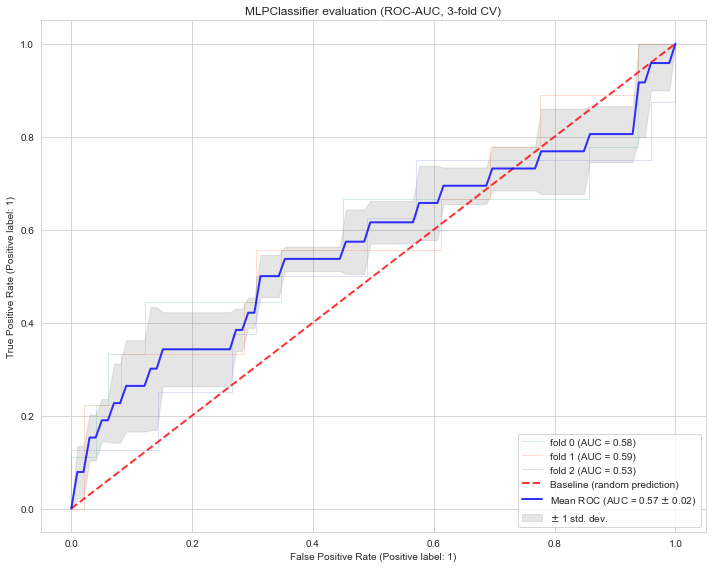

In [37]:
# Plot the ROC curve for MLP (Check code as moved form RF!). 

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=3, shuffle=True)
classifier = resultsGSCV.best_estimator_

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10,8))
for i, (train, test) in enumerate(cv.split(X_eval_sc, y_eval)):
    classifier.fit(X_eval_sc.iloc[train], y_eval[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X_eval_sc.iloc[test],
        y_eval[test],
        name="fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Baseline (random prediction)", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

clfname = [str(step[1].__class__.__name__) for step in classifier.steps if step[0]=='clf'][0]
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f'{clfname} evaluation (ROC-AUC, {nfolds}-fold CV)',
)
ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"{dir_path}/MLP_ROC_curve-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300)
plt.show()

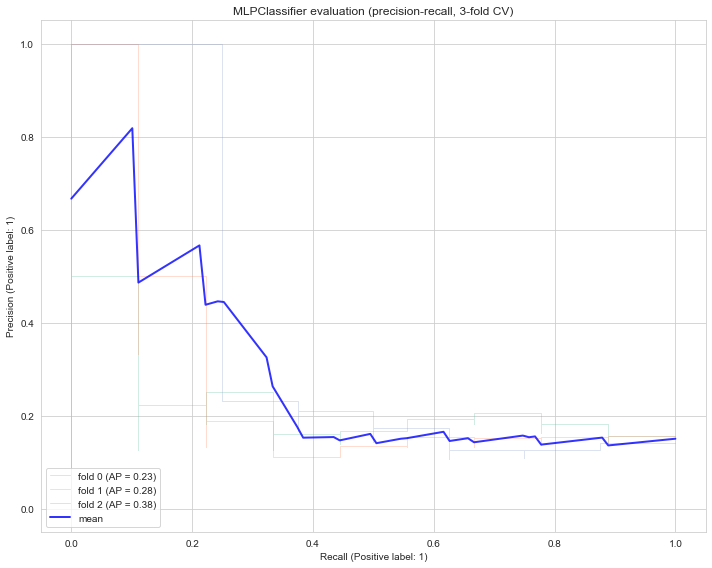

In [38]:
# Plot the mean precision-recall curve for MLP (Check code as moved form RF!). 

from sklearn.metrics import PrecisionRecallDisplay

cv = StratifiedKFold(n_splits=3, shuffle=True)
classifier = resultsGSCV.best_estimator_

prs = []
aucs = []
mean_r = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10,8))
for i, (train, test) in enumerate(cv.split(X_eval_sc, y_eval)):
    classifier.fit(X_eval_sc.iloc[train], y_eval[train])
    viz = PrecisionRecallDisplay.from_estimator(
        classifier,
        X_eval_sc.iloc[test],
        y_eval[test],
        name="fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_pr = np.interp(mean_r, viz.recall[::-1], viz.precision[::-1])
    prs.append(interp_pr)

mean_p = np.mean(prs, axis=0)
ax.plot(
    mean_r,
    mean_p,
    color="b",
    label=f"mean",
    lw=2,
    alpha=0.8,
)
ax.legend(loc="lower left")
clfname = [str(step[1].__class__.__name__) for step in classifier.steps if step[0]=='clf'][0]
ax.set(
    # xlim=[-0.05, 1.05],
    # ylim=[-0.05, 1.05],
    title=f'{clfname} evaluation (precision-recall, {nfolds}-fold CV)')
plt.tight_layout()
plt.savefig(f"{dir_path}/MLP_precision-recall_curve-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300)
plt.show()

#### Feature Importance (MLP)

#### Feature importance with SHAP

First, visualize the impact of all features on both classes in one chart. We are using KernelExplainer but simpler general Explainer should be also tested once the SHAP code fixes all bugs.

**Note: SHAP explanations change between runs because of sampling and probably other random factors!**

In [39]:
# # explain the model's predictions using SHAP
# import shap
# import warnings
# warnings.filterwarnings("ignore")
# shap.initjs()

# explainer = shap.KernelExplainer(NN_model.predict_proba, shap.sample(X_eval_sc,20))
# shap_values = explainer.shap_values(X_eval_sc, nsamples=50)
# shap.summary_plot(shap_values, X_eval_sc, max_display=len(X.columns), class_names=le.classes_)

Now for each class separately. We observe the impact of features on the returned model's probability for a given class.

  0%|          | 0/173 [00:00<?, ?it/s]

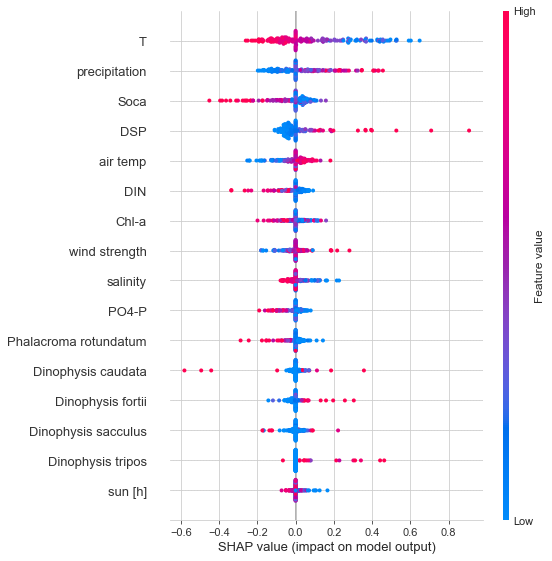

In [40]:
import shap
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
shap.initjs()

explainer = shap.KernelExplainer(nn_clf.predict_proba, shap.sample(X_eval_sc, 50))
shap_values = explainer.shap_values(X_eval_sc, nsamples=50)
classid = 1

# Save shap.summary_plot()
fig = shap.summary_plot(shap_values[classid], X_eval_sc, max_display=len(X_eval_sc.columns), class_names=le.classes_, show=False)
plt.savefig(f"{dir_path}/shap_summary_plot-{classifier_name}-{notebook_name}-{timestamp}.pdf", format="pdf", bbox_inches='tight')

  0%|          | 0/402 [00:00<?, ?it/s]

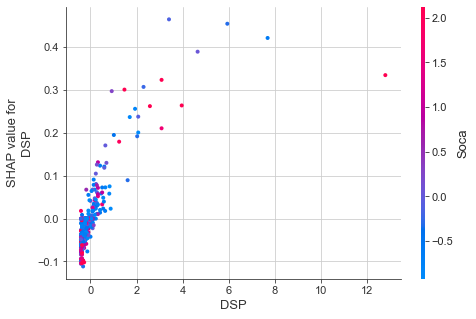

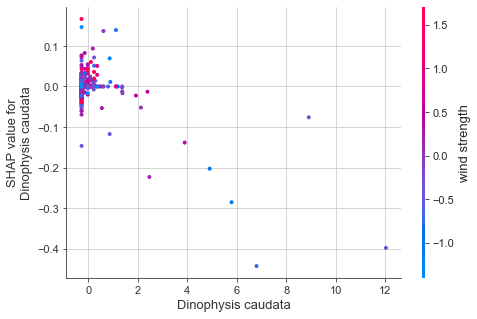

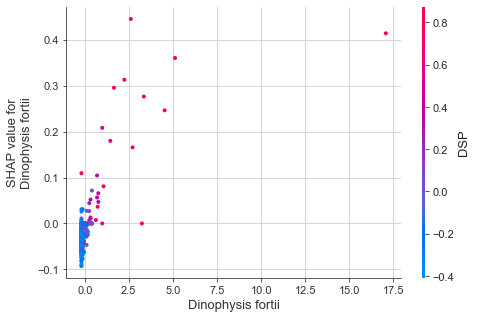

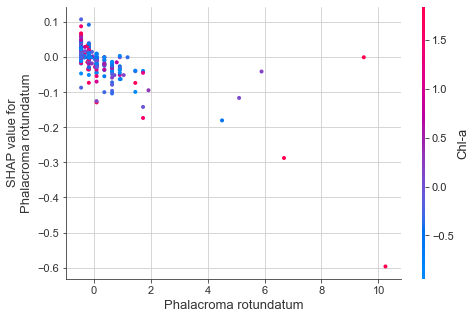

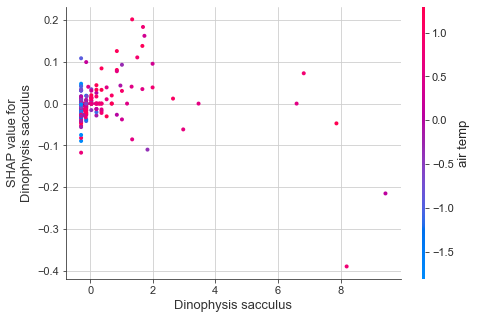

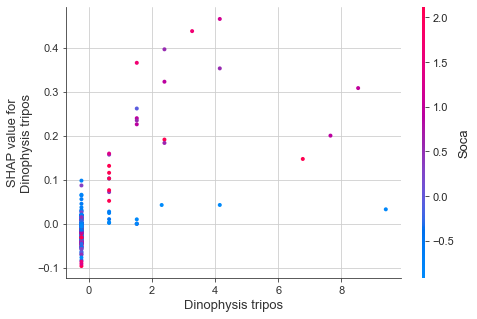

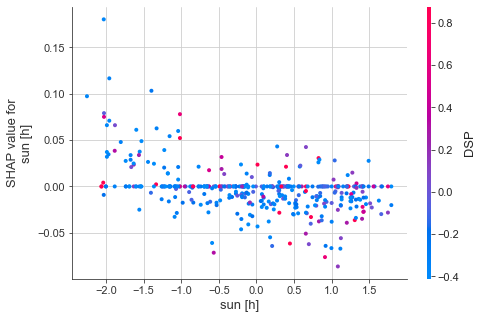

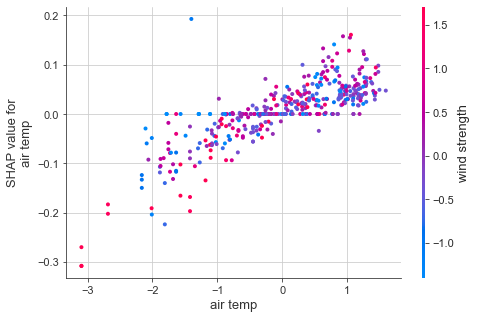

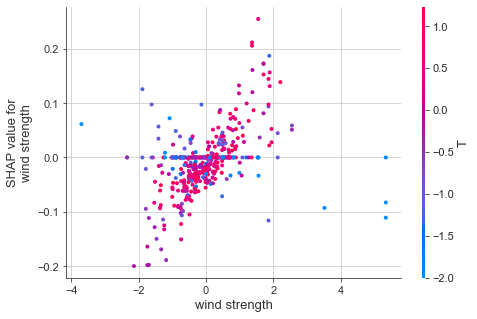

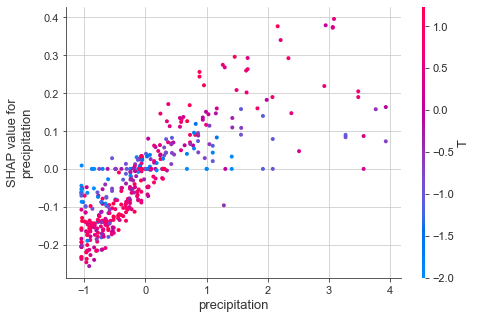

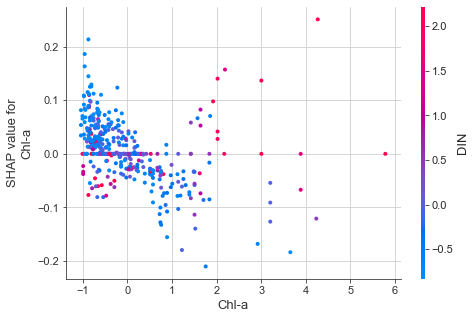

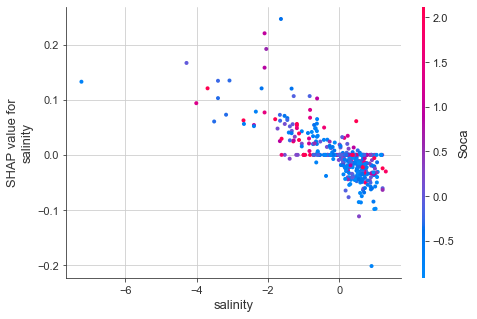

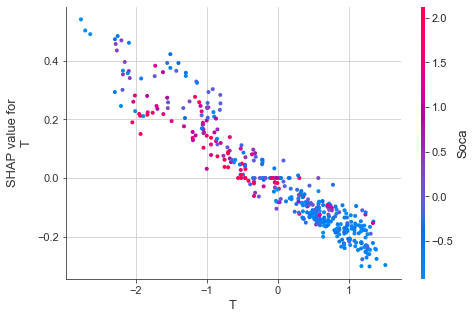

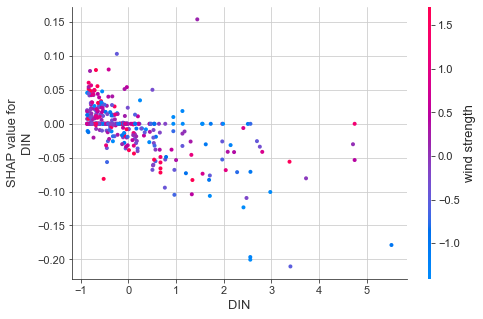

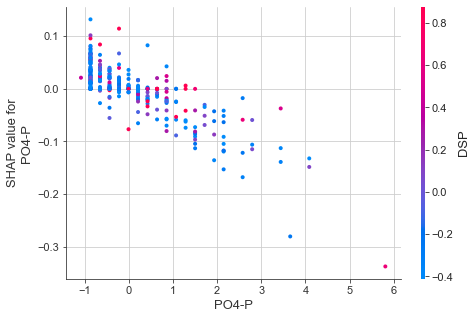

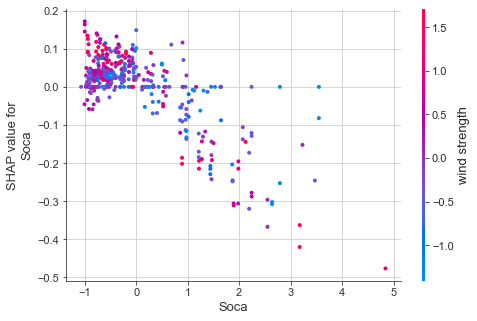

In [41]:
# Try dependence contribution plot
explainer = shap.KernelExplainer(nn_clf.predict_proba, shap.sample(Xsc,50))
shap_values = explainer.shap_values(Xsc, nsamples=50)
for i in Xsc.columns:
    shap.dependence_plot(i, shap_values[1], Xsc,) #interaction_index="salinity"

Example intepretation: The fact this slopes upward says the higher the soca flow, the higher the model's prediction is for poz/neg. The spread suggests that other features must interact with Soca flow. 
In general, high Soca flow increases the chance of poz/neg. But if the sea temp is moderate or low, that trend reverses and even high soca flow does not increase preditions of poz/neg as the sea temp is too low.
https://www.kaggle.com/code/dansbecker/advanced-uses-of-shap-values
---- 
To interpret the dependence contribution plot, look for trends or patterns in the relationship between the 'salinity' feature values and their SHAP values. For example:

If the points show a clear positive trend, it means that as the 'salinity' value increases, its positive contribution to the model's prediction also increases.
If the points show a clear negative trend, it means that as the 'salinity' value increases, its negative contribution to the model's prediction increases (i.e., higher 'salinity' values decrease the probability of class 1).
If there is no clear trend or the points are scattered randomly, it means that there is no strong relationship between the 'salinity' feature values and their SHAP values.
Additionally, observe the colors of the points in the plot. If there is a clear pattern in the colors, it may indicate that the interaction between 'salinity' and the interaction feature has a significant impact on the model's predictions. This can help you identify interactions between features that the model is capturing.

Now let's explain the prediction of a single instance. We will show the explanation of the bigger predicted probability to see why the model decided as it did. But in practice we could be interested only in the explanation of the probability of the positive prediction.

In [42]:
instanceID = 10
instance = Xsc.iloc[[instanceID]]
display_instance = X_display.iloc[[instanceID]]

prediction = nn_clf.predict(instance)[0]
prediction_probs = nn_clf.predict_proba(instance)[0]
print(f'real value: {y[instanceID]}, \npredicted: {prediction}, \npredicted probs: {prediction_probs}')
max_p_id = prediction_probs.argmax()  # we will show the explanation of the bigger predicted probability
print(f'Explanation for prediction: class={max_p_id}, p={prediction_probs.max()}')

explainer = shap.KernelExplainer(nn_clf.predict_proba, shap.sample(Xsc, 50))
shap_values = explainer.shap_values(instance, nsamples=500)
shap.force_plot(explainer.expected_value[max_p_id], shap_values[max_p_id], features=display_instance)

real value: 1, 
predicted: 1, 
predicted probs: [1.25155774e-04 9.99874844e-01]
Explanation for prediction: class=1, p=0.9998748442263283


  0%|          | 0/1 [00:00<?, ?it/s]

Interpretation:

Observe the base value (Expected value) and the prediction line. This gives you an idea of the overall prediction for the instance compared to the average prediction.

Look at the colored arrows and identify the most important features, which are the ones with the longest arrows. These features have the greatest impact on the prediction.

Analyze the direction and color of the arrows to understand whether each feature increases or decreases the probability of the positive class (class 1) and whether the feature values are high or low.

Consider the interactions between the features and their combined impact on the prediction.

By analyzing the force plot, you can gain insights into the contributions of each feature to the model's prediction for a specific instance, helping you understand the model's decision-making process.

### LIME

In [43]:
import lime
from lime import lime_tabular

# Create a LIME explainer object
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(Xsc),
    feature_names=Xsc.columns,
    class_names=le.classes_,
    mode='classification'
)

# Exaplain an instance
instanceID = 100
lime_exp = lime_explainer.explain_instance(
    data_row=Xsc.iloc[instanceID], 
    predict_fn=nn_clf.predict_proba
)

lime_exp.show_in_notebook(show_table=True)

# Save the LIME explanation as an image file
# fig = lime_exp.as_pyplot_figure(label=1)
# plt.savefig(f"{dir_path}/lime_explanation-{classifier_name}-{notebook_name}-{timestamp}.pdf", format="pdf", bbox_inches='tight')

### Conclusion

In [44]:
# Define a function to extract the metrics from the classification report dictionary
def extract_metrics(report_dict):
    metrics = {}
    for class_label in report_dict:
        if class_label in ('accuracy', 'macro avg', 'weighted avg'):
            continue
        metrics[class_label] = {
            'precision': report_dict[class_label]['precision'],
            'recall': report_dict[class_label]['recall'],
            'f1-score': report_dict[class_label]['f1-score'],
            'support': report_dict[class_label]['support']
        }
    return metrics

# Extract the metrics for each classifier
SVM_metrics = extract_metrics(SVM_report_dict)
DT_metrics = extract_metrics(DT_report_dict)
RF_metrics = extract_metrics(RF_report_dict)
NN_metrics = extract_metrics(NN_report_dict)

# Create a dictionary to store the metrics for each classifier
classifier_metrics = {
    'Support Vector Mashines': SVM_metrics,
    'Decision Tree': DT_metrics,
    'Random Forest': RF_metrics,
    'Neural Network': NN_metrics
}

# Convert the dictionary to a pandas DataFrame
summary_df = pd.concat({k: pd.DataFrame(v).transpose() for k, v in classifier_metrics.items()}, axis=0)
summary_df.reset_index(inplace=True)
summary_df.columns = ['Classifier', 'Class', 'Precision', 'Recall', 'F1-score', 'Support']

# Map the original class labels to the new names
class_name_mapping = {
    '0': 'neg',
    '1': 'poz'
}
summary_df['Class'] = summary_df['Class'].map(class_name_mapping)

# Filter the summary DataFrame to display only the 'poz' class
poz_summary_df = summary_df.query("Class == 'poz'")

# Display the filtered summary DataFrame
poz_summary_df

,Classifier,Class,Precision,Recall,F1-score,Support
1,Support Vector Mashines,poz,0.295082,0.692308,0.413793,26.0
3,Decision Tree,poz,0.354167,0.653846,0.459459,26.0
5,Random Forest,poz,0.377778,0.653846,0.478873,26.0
7,Neural Network,poz,0.230769,0.461538,0.307692,26.0


In [45]:
# Format table

poz_summary_df = poz_summary_df.round(2)
poz_summary_df = poz_summary_df.set_index('Classifier')
poz_summary_df = poz_summary_df.drop(['Support', "Class"], axis=1)
# poz_summary_df = poz_summary_df.style.highlight_max(subset=['Precision', 'Recall', 'F1-score'], color='green')
poz_summary_df.to_csv(f"{dir_path}/results_summary_df.csv")
poz_summary_df

,Precision,Recall,F1-score
Classifier,,,
Support Vector Mashines,0.30,0.69,0.41
Decision Tree,0.35,0.65,0.46
Random Forest,0.38,0.65,0.48
Neural Network,0.23,0.46,0.31
